In [12]:
!pip install pretty_midi

In [ ]:
import glob

dataset_path = "/content/drive/MyDrive/DL Lab - 2nd Sem/Lab 5/Dataset/maestro-v3.0.0/"
# Get all MIDI files recursively from subdirectories
midi_files = glob.glob(os.path.join(dataset_path, "**/*.midi"), recursive=True)
midi_files += glob.glob(os.path.join(dataset_path, "**/*.mid"), recursive=True)

print(f"Total MIDI files found: {len(midi_files)}")

NameError: name 'os' is not defined

In [13]:
import numpy as np
import os
import pretty_midi
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from concurrent.futures import ProcessPoolExecutor

In [14]:
dataset_path = "/content/drive/MyDrive/DL Lab - 2nd Sem/Lab 5/Dataset/maestro-v3.0.0/"
midi_files = glob.glob(os.path.join(dataset_path, "**/*.midi"), recursive=True)
midi_files += glob.glob(os.path.join(dataset_path, "**/*.mid"), recursive=True)

print(f"Total MIDI files: {len(midi_files)}")

Total MIDI files: 50


In [15]:
# Function to extract MIDI note sequences
def midi_to_notes(midi_file):
    try:
        pm = pretty_midi.PrettyMIDI(midi_file)
        notes = [
            [note.start, note.end, note.pitch, note.velocity]
            for instrument in pm.instruments for note in instrument.notes
        ]
        return np.array(notes) if notes else np.empty((0, 4))
    except Exception as e:
        print(f"Error processing {midi_file}: {e}")
        return np.empty((0, 4))

# Process all MIDI files in parallel
with ProcessPoolExecutor() as executor:
    all_notes = list(executor.map(midi_to_notes, midi_files))

all_notes = np.concatenate([n for n in all_notes if n.size > 0], axis=0)

# Exploratory Data Analysis
plt.figure(figsize=(10, 4))
sns.histplot(all_notes[:, 2], bins=50, kde=True, color="blue")
plt.xlabel("MIDI Pitch")
plt.ylabel("Frequency")
plt.title("Pitch Distribution in MAESTRO Dataset")
plt.show()

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [ ]:
# Convert MIDI to piano roll representation
def midi_to_piano_roll(midi_file, fs=100):
    try:
        pm = pretty_midi.PrettyMIDI(midi_file)
        return pm.get_piano_roll(fs=fs).T
    except Exception as e:
        print(f"Error processing {midi_file}: {e}")
        return np.zeros((1000, 128))

# Process MIDI to piano roll in parallel
with ProcessPoolExecutor() as executor:
    piano_rolls = list(executor.map(midi_to_piano_roll, midi_files))

# Pad sequences to a fixed length
MAX_LENGTH = 1000
piano_rolls = [
    x[:MAX_LENGTH] if x.shape[0] > MAX_LENGTH else np.pad(x, ((0, MAX_LENGTH - x.shape[0]), (0, 0)))
    for x in piano_rolls
]
X = np.array(piano_rolls)

In [ ]:
# Data Splitting
X_train, X_temp = train_test_split(X, test_size=0.3, random_state=42)
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)

# Normalize Data
X_train, X_val, X_test = X_train / 127.0, X_val / 127.0, X_test / 127.0

# Define LSTM Model
model = keras.Sequential([
    layers.LSTM(128, return_sequences=True, input_shape=(MAX_LENGTH, X_train.shape[2])),
    layers.LSTM(64, return_sequences=True),
    layers.TimeDistributed(layers.Dense(X_train.shape[2], activation='sigmoid'))
])

# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train Model
history = model.fit(X_train, X_train, epochs=100, validation_data=(X_val, X_val), batch_size=16)

# Evaluate Model
loss, accuracy = model.evaluate(X_test, X_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Generate Music
generated_sequence = model.predict(X_test[:1])

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 70s 9s/step - accuracy: 0.0628 - loss: 0.6924 - val_accuracy: 0.0029 - val_loss: 0.6834
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.0029 - loss: 0.6802 - val_accuracy: 1.4286e-04 - val_loss: 0.6571
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.0059 - loss: 0.6459 - val_accuracy: 1.4286e-04 - val_loss: 0.5645
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.0062 - loss: 0.5510 - val_accuracy: 1.4286e-04 - val_loss: 0.4796
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.0071 - loss: 0.4717 - val_accuracy: 1.4286e-04 - val_loss: 0.4106
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.0100 - loss: 0.4036 - val_accuracy: 1.4286e-04 - val_loss: 0.3454
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.0064 - loss: 0.3401 - val_accuracy: 1.4286e-04 - val_loss: 0.2879
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.0105 - loss: 0.2857 - val_accuracy: 1.4

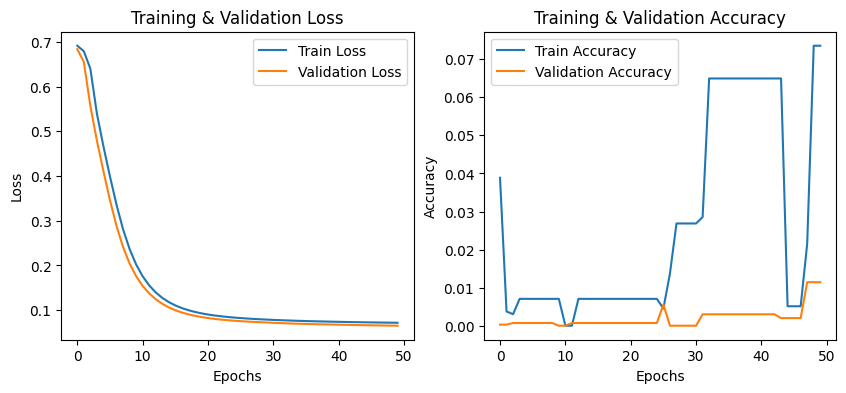

In [ ]:
def piano_roll_to_midi(piano_roll, fs=100):
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)
    for time, pitch_vector in enumerate(piano_roll):
        for pitch, velocity in enumerate(pitch_vector):
            if velocity > 0:
                note = pretty_midi.Note(
                    velocity=int(velocity * 127),
                    pitch=pitch,
                    start=time / fs,
                    end=(time + 1) / fs
                )
                instrument.notes.append(note)
    pm.instruments.append(instrument)
    return pm

generated_midi = piano_roll_to_midi(generated_sequence[0])
generated_midi.write("generated_music.mid")

# Plot Training Loss & Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Ensure GPU is used
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

# Optimized LSTM Model
model = keras.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(MAX_LENGTH, X_train.shape[2]),
                activation='tanh', recurrent_activation='sigmoid', use_bias=True),
    layers.LSTM(32, return_sequences=True,
                activation='tanh', recurrent_activation='sigmoid', use_bias=True),
    layers.TimeDistributed(layers.Dense(X_train.shape[2], activation='sigmoid'))
])

# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train Model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=50)

# Evaluate Model
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")


Num GPUs Available: 0
Epoch 1/50


ValueError: None values not supported.